## Imports

In [20]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [70]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = dset.ImageFolder('../Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('../Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('../Dataset/test', transform=transform)

In [71]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [40]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Creating ResNet model

In [41]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 172)
optimizer = optim.Adam(model.parameters())
print(model)
model = gpu(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training the model

In [42]:
def train_model(model, optimizer, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        model.train()
        batches = train_dataloader
        num_correct, num_samples, total_loss = 0, 0, 0
        for x, y in batches:
            x, y = gpu(x), gpu(y)
            scores = model(x)
            loss = F.cross_entropy(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(scores.data,1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = val_dataloader
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(x), gpu(y)                
            scores = model(x)
            loss = F.cross_entropy(scores, y) 
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        

In [43]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model), optimizer, epochs=20)

Epoch: 1 Training Loss: 0.0330 Got 30683 / 66071 correct. Acc: 46.44%
Epoch: 1 Validation Loss: 0.0298 Got 5557 / 11016 correct 50.44%
Epoch: 2 Training Loss: 0.0192 Got 43526 / 66071 correct. Acc: 65.88%
Epoch: 2 Validation Loss: 0.0230 Got 6687 / 11016 correct 60.70%
Epoch: 3 Training Loss: 0.0139 Got 49124 / 66071 correct. Acc: 74.35%
Epoch: 3 Validation Loss: 0.0214 Got 7062 / 11016 correct 64.11%
Epoch: 4 Training Loss: 0.0101 Got 53412 / 66071 correct. Acc: 80.84%
Epoch: 4 Validation Loss: 0.0192 Got 7503 / 11016 correct 68.11%
Epoch: 5 Training Loss: 0.0073 Got 56507 / 66071 correct. Acc: 85.52%
Epoch: 5 Validation Loss: 0.0231 Got 7325 / 11016 correct 66.49%
Epoch: 6 Training Loss: 0.0055 Got 58750 / 66071 correct. Acc: 88.92%
Epoch: 6 Validation Loss: 0.0234 Got 7368 / 11016 correct 66.88%
Epoch: 7 Training Loss: 0.0042 Got 60355 / 66071 correct. Acc: 91.35%
Epoch: 7 Validation Loss: 0.0238 Got 7387 / 11016 correct 67.06%
Epoch: 8 Training Loss: 0.0036 Got 61319 / 66071 correc

In [45]:
# Save the model.
PATH = "../saved_models/food/res18/res18.dat"
torch.save(model, PATH)
torch.save({'loss': LOSS, 'acc': ACC, 'loss_v': LOSS_V, 'acc_v': ACC_V}, '../saved_models/food/res18/res18-history.pt')

## Evaluation

In [3]:
# Load the model.
PATH = "../saved_models/food/res18/res18.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/res18/res18-history.pt')
LOSS, ACC, LOSS_V, ACC_V = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

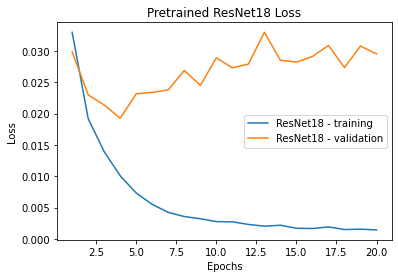

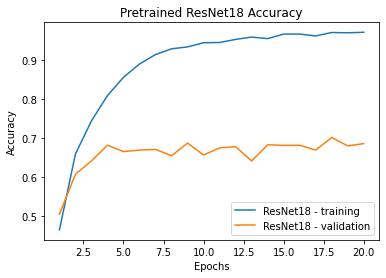

In [21]:
# Loss and Accuracy Curves
from utils.plots import plot_loss_and_accuracy_curves
plot_loss_and_accuracy_curves('ResNet18', LOSS, ACC, LOSS_V, ACC_V)

In [47]:
# Evaluation: Top-1 Accuracy

def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Top 1 Accuracy of the network on the all test images: 68.17 %


In [48]:
# Evaluation: Top-5 Accuracy

def compute_top_5_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            for i in range(predicted.shape[0]):
                top_5_predictions = predicted[i]
                label = labels[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 5 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_5_accuracy(model)

Top 5 Accuracy of the network on the all test images: 89.38 %


In [49]:
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [50]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
with torch.no_grad():
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(labels.cpu().numpy().tolist())

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [51]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)
print(cnf_matrix[0][0], sum(cnf_matrix[0]))

Confusion Matrix

[[177   7   0 ...   0   2   0]
 [  3 222   0 ...   0   0   0]
 [  0   0  36 ...   0   0   0]
 ...
 [  0   0   0 ...  66   0   0]
 [  0   0   0 ...   0  48   1]
 [  0   0   0 ...   0   0 145]]
177 307


<AxesSubplot:>

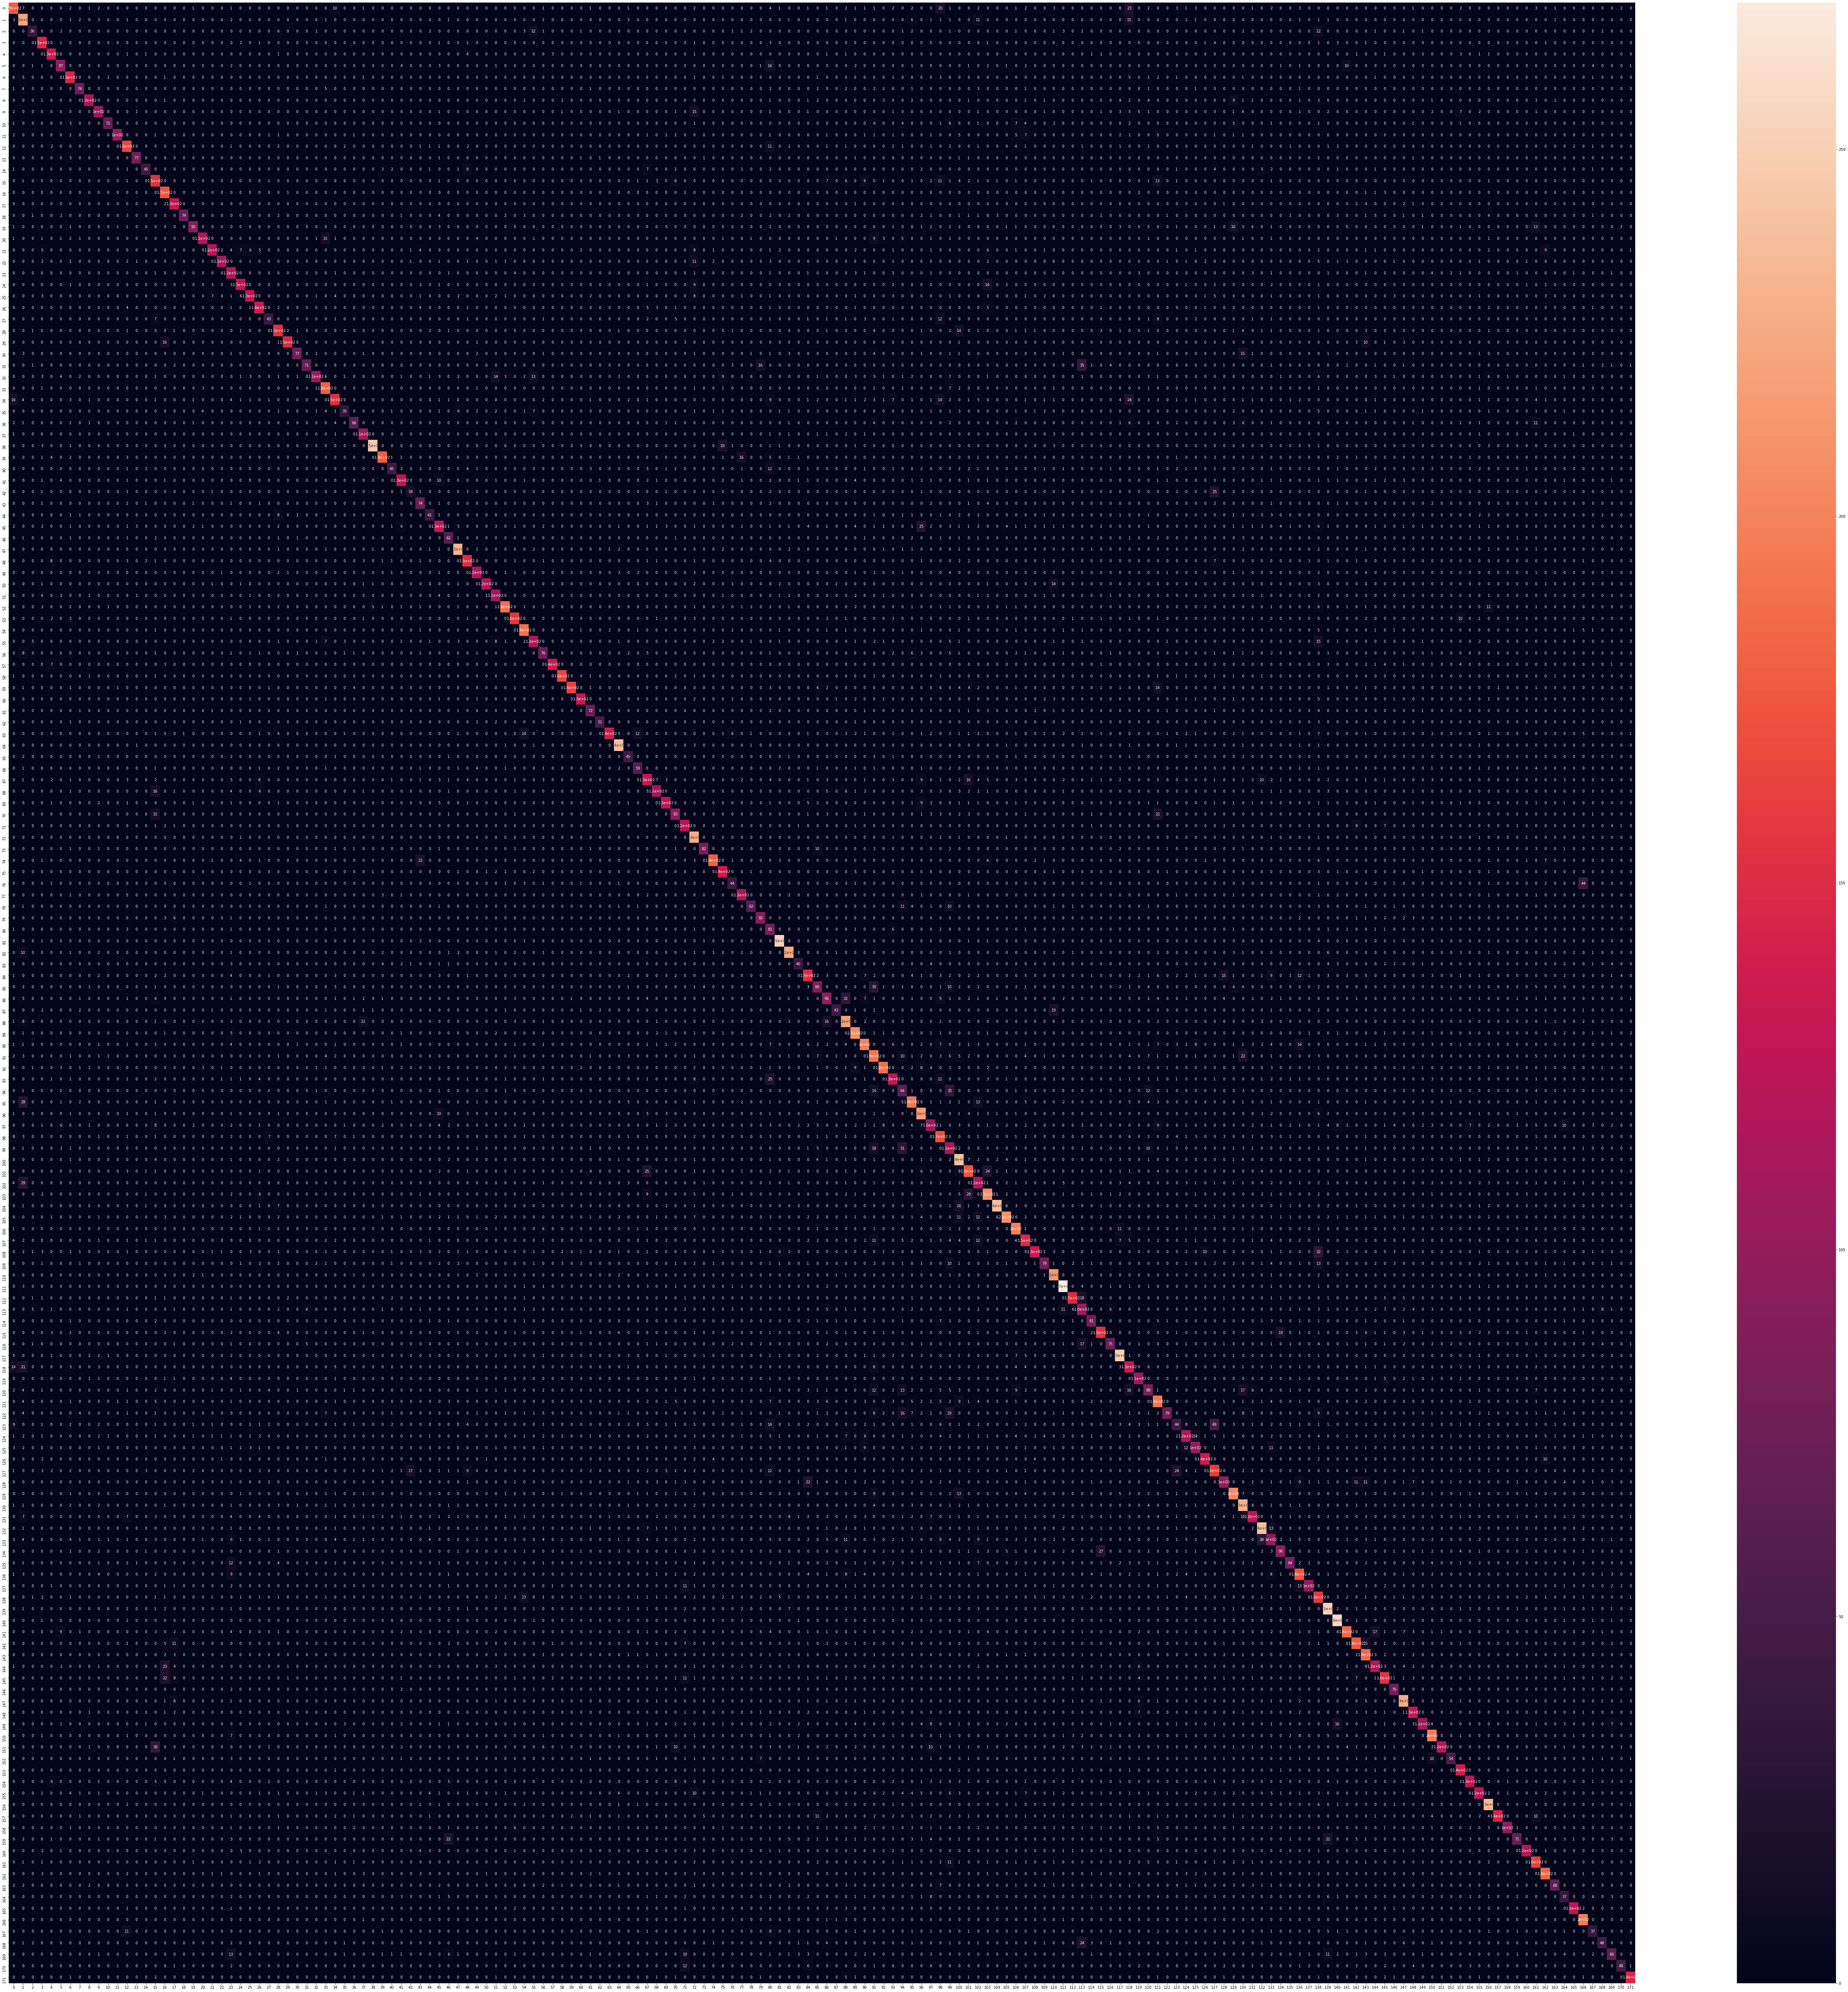

In [61]:
# Visualizing the confusion matrix 

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cnf_matrix.tolist()
df_cm = pd.DataFrame(array, index = [i for i in range(172)],
                  columns = [i for i in range(172)])
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)

In [57]:
# Evaluation: Compute several statistics such as accuracy, precision, F1-score, and produce a classification report

FOOD_LIST_PATH = '../VireoFood172/SplitAndIngreLabel/FoodList.txt'
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()
    
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=food_names))


Accuracy: 0.68

Micro Precision: 0.68
Micro Recall: 0.68
Micro F1-score: 0.68

Macro Precision: 0.71
Macro Recall: 0.67
Macro F1-score: 0.68

Weighted Precision: 0.71
Weighted Recall: 0.68
Weighted F1-score: 0.68

Classification Report

                                              precision    recall  f1-score   support

                                Braised Pork       0.63      0.58      0.60       307
                          Sautéed Spicy Pork       0.52      0.77      0.62       287
             Cripsy sweet & sour pork slices       0.63      0.37      0.46        98
               Steamed pork with rice powder       0.70      0.87      0.77       168
                  Pork with salted vegetable       0.75      0.86      0.80       156
                   Shredded Pork with pepper       0.70      0.64      0.67       152
                     Yu-Shiang Shredded Pork       0.65      0.82      0.73       178
  Sautéed Sliced Pork, Eggs and Black Fungus       0.76      0.72      0.

In [58]:
print(len(y_test))

33154


In [67]:
# Class 0 Statistics

TP = 0
FP = 0
FN = 0
for pred,label in zip(y_pred, y_test):
    if pred == 0 and label == 0:
        TP += 1
    if pred == 0 and label != 0:
        FP += 1
    if pred != 0 and label == 0:
        FN += 1
print("Class 0 ({}) Statistics".format(food_names[0]))
print("True Positives: {}".format(TP))
print("False Positives: {}".format(FP))
print("False Negatives: {}".format(FN))
print("Precision: {}".format(TP / (TP + FP)))
print("Recall: {}".format(TP / (TP + FN)))

Class 0 (Braised Pork) Statistics
True Positives: 177
False Positives: 106
False Negatives: 130
Precision: 0.6254416961130742
Recall: 0.5765472312703583


## Training the model (freeze all weights except last linear layer)

In [13]:
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
model = nn.Sequential(nn.ReLU(inplace=True), nn.Linear(1000, 172))
print(model)

Sequential(
  (0): ReLU(inplace=True)
  (1): Linear(in_features=1000, out_features=172, bias=True)
)


In [15]:
model = gpu(model)

In [16]:
def load_array(fname):
    return bcolz.open(fname)[:]

In [17]:
conv_feat_val = load_array('../res50/feat_val.bc')
labels_val = load_array('../res50/labels_val.bc')

In [18]:
print(len(conv_feat_val))
print(conv_feat_val.shape)

11016
(11016, 1000)


In [19]:
optimizer = optim.Adam(model.parameters())

### Creating Data generator

In [20]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [21]:
def data_gen_train():
    for i in range(0, 11):
        conv_feat = load_array('../res50/feat_train_{}.bc'.format(i))
        labels = load_array('../res50/labels_train_{}.bc'.format(i))
        yield from data_gen(conv_feat, labels)

In [22]:
def train_model(model, optimizer, conv_feat_val, labels_val, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        model.train()
        batches = data_gen_train()
        num_correct, num_samples, total_loss = 0, 0, 0
        for x, y in batches:
            x, y = gpu(torch.from_numpy(x)), gpu(torch.from_numpy(y))
            x = x.view(x.size(0), -1)
            scores = model(x)
            loss = F.cross_entropy(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(scores.data,1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, conv_feat_val, labels_val, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, conv_feat_val, labels_val, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = data_gen(conv_feat=conv_feat_val, labels=labels_val)
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(torch.from_numpy(x)), gpu(torch.from_numpy(y))                
            x = x.view(x.size(0), -1)
            scores = model(x)
            loss = F.cross_entropy(scores, y) 
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        

In [23]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model), optimizer, conv_feat_val, labels_val, epochs=50)

Epoch: 1 Training Loss: 0.0364 Got 29519 / 66071 correct. Acc: 44.68%
Epoch: 1 Validation Loss: 0.0973 Got 756 / 11016 correct 6.86%
Epoch: 2 Training Loss: 0.0254 Got 38554 / 66071 correct. Acc: 58.35%
Epoch: 2 Validation Loss: 0.1036 Got 766 / 11016 correct 6.95%
Epoch: 3 Training Loss: 0.0224 Got 41356 / 66071 correct. Acc: 62.59%
Epoch: 3 Validation Loss: 0.1082 Got 777 / 11016 correct 7.05%
Epoch: 4 Training Loss: 0.0204 Got 43365 / 66071 correct. Acc: 65.63%
Epoch: 4 Validation Loss: 0.1116 Got 803 / 11016 correct 7.29%
Epoch: 5 Training Loss: 0.0188 Got 44867 / 66071 correct. Acc: 67.91%
Epoch: 5 Validation Loss: 0.1145 Got 791 / 11016 correct 7.18%
Epoch: 6 Training Loss: 0.0176 Got 46053 / 66071 correct. Acc: 69.70%
Epoch: 6 Validation Loss: 0.1179 Got 783 / 11016 correct 7.11%
Epoch: 7 Training Loss: 0.0166 Got 46922 / 66071 correct. Acc: 71.02%
Epoch: 7 Validation Loss: 0.1210 Got 796 / 11016 correct 7.23%
Epoch: 8 Training Loss: 0.0157 Got 47875 / 66071 correct. Acc: 72.46%